## COMPOSITE
COMPOSITE (COMpound POiSson multIplet deTEction model) works for RNA, ADT, and ATAC modality.
### Setup and Load Data
Data files are in the 'filtered_feature_bc_matrix' folder along with other output from CellRanger. 

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os

# For COMPOSITE
import sccomposite # pip install torch if necessary
from sccomposite import RNA_modality # There are other modalities, but irrelevant for this project
import anndata

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

sample_name = r'sc85_1g' #r'sc70_1' #r'sc72_1'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13
scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


#### Load data

Read in count data into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.  
The matrix.mtx file contains a sparse matrix of the counts.  
Barcodes file contains the sample names in the format: AAACCCAAGACCATAA-1  
Features file contains the gene id in the format: ENSMUSG00000051951, Xkr4, Gene Expression

The number of counts per cell will be relatively low since only UMIs are counted by Cellranger

In [2]:
adata = anndata.read_h5ad("pseudo_doublets_sc85_1g_2.0.h5ad")                # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

print()
print(adata.obs)

Data matrix is sparse: True

Number of cells = 12,184
Number of genes = 25,051
Number of counts = 8,337,388
Mean counts per cell = 684

Empty DataFrame
Columns: []
Index: [rDbl.1, rDbl.2, rDbl.3, rDbl.4, rDbl.5, rDbl.6, rDbl.7, rDbl.8, rDbl.9, rDbl.10, rDbl.11, rDbl.12, rDbl.13, rDbl.14, rDbl.15, rDbl.16, rDbl.17, rDbl.18, rDbl.19, rDbl.20, rDbl.21, rDbl.22, rDbl.23, rDbl.24, rDbl.25, rDbl.26, rDbl.27, rDbl.28, rDbl.29, rDbl.30, rDbl.31, rDbl.32, rDbl.33, rDbl.34, rDbl.35, rDbl.36, rDbl.37, rDbl.38, rDbl.39, rDbl.40, rDbl.41, rDbl.42, rDbl.43, rDbl.44, rDbl.45, rDbl.46, rDbl.47, rDbl.48, rDbl.49, rDbl.50, rDbl.51, rDbl.52, rDbl.53, rDbl.54, rDbl.55, rDbl.56, rDbl.57, rDbl.58, rDbl.59, rDbl.60, rDbl.61, rDbl.62, rDbl.63, rDbl.64, rDbl.65, rDbl.66, rDbl.67, rDbl.68, rDbl.69, rDbl.70, rDbl.71, rDbl.72, rDbl.73, rDbl.74, rDbl.75, rDbl.76, rDbl.77, rDbl.78, rDbl.79, rDbl.80, rDbl.81, rDbl.82, rDbl.83, rDbl.84, rDbl.85, rDbl.86, rDbl.87, rDbl.88, rDbl.89, rDbl.90, rDbl.91, rDbl.92, rDbl.93, 

In [3]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame([n_cells, n_genes, n_counts, counts_per_cell], \
                  index = ['Number of cells', 'Number of genes', 'Number of counts','Mean counts per cell']).T
df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_18324\1815972615.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_18324\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    25,051
Name: Number of genes, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_18324\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    8,337,388
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_1g,12184.0,"25,051","8,337,388",684


### Detect doublets

In [4]:
# Didn't necessarily say to remove "empty" genes
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 1054 genes that are detected in less than 1 cells


In [5]:
print(adata.X)                
print(adata.var)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6409924 stored elements and shape (12184, 23997)>
  Coords	Values
  (0, 17)	1.0
  (0, 37)	1.0
  (0, 80)	1.0
  (0, 98)	1.0
  (0, 120)	1.0
  (0, 160)	1.0
  (0, 170)	1.0
  (0, 195)	2.0
  (0, 212)	1.0
  (0, 219)	1.0
  (0, 302)	1.0
  (0, 325)	1.0
  (0, 338)	1.0
  (0, 393)	1.0
  (0, 421)	2.0
  (0, 433)	1.0
  (0, 462)	1.0
  (0, 464)	1.0
  (0, 482)	1.0
  (0, 526)	1.0
  (0, 532)	1.0
  (0, 589)	1.0
  (0, 591)	1.0
  (0, 612)	1.0
  (0, 641)	2.0
  :	:
  (12183, 22800)	1.0
  (12183, 22886)	1.0
  (12183, 22914)	1.0
  (12183, 22917)	1.0
  (12183, 22991)	1.0
  (12183, 23119)	1.0
  (12183, 23141)	1.0
  (12183, 23145)	1.0
  (12183, 23184)	1.0
  (12183, 23213)	1.0
  (12183, 23287)	1.0
  (12183, 23370)	2.0
  (12183, 23386)	1.0
  (12183, 23420)	1.0
  (12183, 23461)	1.0
  (12183, 23480)	1.0
  (12183, 23522)	1.0
  (12183, 23550)	3.0
  (12183, 23561)	1.0
  (12183, 23624)	1.0
  (12183, 23627)	1.0
  (12183, 23672)	3.0
  (12183, 23961)	1.0
  (12183, 23

In [6]:
from scipy.io import mmwrite

os.makedirs("mtx", exist_ok=True)
mmwrite("mtx/RNA.mtx", adata.X.T)

In [7]:
import scipy.io as sio
mtx_data = sio.mmread("mtx/RNA.mtx")
print("Matrix shape:", mtx_data.shape)
print("Sparsity:", 1.0 - (mtx_data.nnz / (mtx_data.shape[0] * mtx_data.shape[1])))

Matrix shape: (23997, 12184)
Sparsity: 0.9780766943646463


In [8]:
print(adata.X.T)

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 6409924 stored elements and shape (23997, 12184)>
  Coords	Values
  (17, 0)	1.0
  (37, 0)	1.0
  (80, 0)	1.0
  (98, 0)	1.0
  (120, 0)	1.0
  (160, 0)	1.0
  (170, 0)	1.0
  (195, 0)	2.0
  (212, 0)	1.0
  (219, 0)	1.0
  (302, 0)	1.0
  (325, 0)	1.0
  (338, 0)	1.0
  (393, 0)	1.0
  (421, 0)	2.0
  (433, 0)	1.0
  (462, 0)	1.0
  (464, 0)	1.0
  (482, 0)	1.0
  (526, 0)	1.0
  (532, 0)	1.0
  (589, 0)	1.0
  (591, 0)	1.0
  (612, 0)	1.0
  (641, 0)	2.0
  :	:
  (22800, 12183)	1.0
  (22886, 12183)	1.0
  (22914, 12183)	1.0
  (22917, 12183)	1.0
  (22991, 12183)	1.0
  (23119, 12183)	1.0
  (23141, 12183)	1.0
  (23145, 12183)	1.0
  (23184, 12183)	1.0
  (23213, 12183)	1.0
  (23287, 12183)	1.0
  (23370, 12183)	2.0
  (23386, 12183)	1.0
  (23420, 12183)	1.0
  (23461, 12183)	1.0
  (23480, 12183)	1.0
  (23522, 12183)	1.0
  (23550, 12183)	3.0
  (23561, 12183)	1.0
  (23624, 12183)	1.0
  (23627, 12183)	1.0
  (23672, 12183)	3.0
  (23961, 12183)	1.0
  (23981,

In [9]:
print(os.path.exists("mtx/RNA.mtx"))
multiplet_classification, consistency = RNA_modality.composite_rna("mtx/RNA.mtx")
# was receiving errors around the float128, changed this to float64 in the source code

True
Cuda is not available; Fitting the COMPOSITE model on RNA modality
The RNA modality goodness-of-fit score is: 3.1950113512524023 
<3: poor fit 
3~5: moderate fit 
>5: good fit


In [10]:
multiplets = [1.0 if x == 1 else 0 for x in multiplet_classification]
adata.obs["COMPOSITE_class"] = multiplet_classification
adata.obs["multiplets"] = multiplets

In [11]:
multiplet_percentage = sum(multiplets)/adata.n_obs*100
print('multiplet percentage = %4.1f' %(multiplet_percentage))
df_metrics['Multiplet removal:'] = ' '
df_metrics['Multiplet percentage'] =  multiplet_percentage

multiplet percentage =  0.0


In [12]:
num_before = adata.n_obs
singlets = adata.obs["COMPOSITE_class"] == 0
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before multiplet removal =', num_before)
print('Number of cells after multiplet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After multiplet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before multiplet removal = 12184
Number of cells after multiplet removal = 12184
Number of cells removed = 0
Percentage of cells removed =  0.0
Number of counts = 8,337,388
Mean counts per cell = 684


### UMAP
Visualize the data before and after doublet removal.

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)


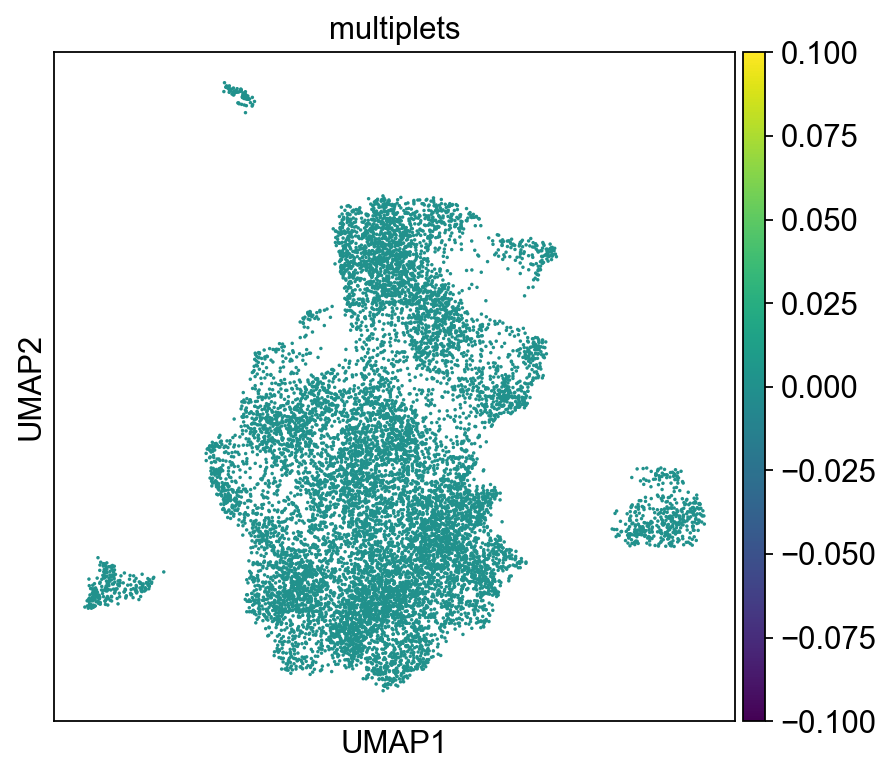

In [14]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color=['multiplets'])

### Exporting Doublets to a `.txt` file
Printing out doublet subsets for future comparisons

In [15]:
print(adata.obs[adata.obs['COMPOSITE_class'] == 1])
adata_dbl = adata[adata.obs['COMPOSITE_class'] == 1].copy()

Empty DataFrame
Columns: [COMPOSITE_class, multiplets]
Index: []


In [16]:
print(adata_dbl.obs_names)

Index([], dtype='object')


In [17]:
with open("./sc85_1g_IDs/COMPOSITE_sc85_1g_pseudo_2.0_ids.txt", "w") as txt_file:
    for cell in adata_dbl.obs_names:
        txt_file.write(cell + "\n")